# Introduction

Based on https://github.com/facebookresearch/SymbolicMathematics, we are trying to extend the function of the model of Interal.

1. In the paper, integration and first and second order differential equations are researched. We only focus on integration.

2. In the paper, for the expression tree, only very limited values are supported.

In the original paper, the dataset is limmited to:

```
      *• expressions with up to n = 15 internal nodes*

      *• L = 11 leaf values in {x} ∪ {−5, . . . , 5} \ {0}*

      *• p2 = 4 binary operators: +, −, ×, /*

      • p1 = 15 unary operators: exp, log, sqrt, sin, cos, tan, sin-1, cos-1 , tan-1, sinh, cosh, tanh, sinh-1, cosh-1, tanh-1*
```


Here we are trying to:

```
      *To support all real values as leaf values, in other words,
      leaf values in {x} ∪ R \ {0}*
```


3. In the paper, three methods have been used to generate the dataset:

      Forward generation (FWD), 

      Backward generation (BWD),

      Backward generation with integration by parts (IBP). 

Here, due to the new challenge of the parametered sample, the Backward genration (BWD) is not reliable. To save time, we only use **Forward generation (FWD)** method to generate dataset.



# To setup environment

## To copy related source code

The source code is copied from https://github.com/facebookresearch/SymbolicMathematics.

In [10]:
!wget https://github.com/facebookresearch/SymbolicMathematics/archive/refs/heads/master.zip

--2021-05-31 09:33:10--  https://github.com/facebookresearch/SymbolicMathematics/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/SymbolicMathematics/zip/refs/heads/master [following]
--2021-05-31 09:33:10--  https://codeload.github.com/facebookresearch/SymbolicMathematics/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.1’

master.zip.1            [ <=>                ]  61.20K  --.-KB/s    in 0.007s  

2021-05-31 09:33:10 (9.13 MB/s) - ‘master.zip.1’ saved [62669]



In [11]:
!pwd

/content


In [12]:
!cp /content/SymbolicMathematics-master/src src -r

## To upgrade Sympy when needed

In [13]:
# pip install --upgrade sympy

## To import basic packages

In [14]:
import os
import numpy as np
import sympy as sp
import torch
import sys
from src.utils import AttrDict
from src.envs import build_env
from src.model import build_modules

from src.utils import to_cuda
from src.envs.sympy_utils import simplify

## To Build SymbolicMathematics environment

We will use the original code to deal with basic expression process.

In [15]:
params = params = AttrDict({

    # environment parameters
    'env_name': 'char_sp',
    'int_base': 10,
    'balanced': False,
    'positive': True,
    'precision': 10,
    'n_variables': 1,
    'n_coefficients': 0,
    'leaf_probs': '0.75,0,0.25,0',
    'max_len': 512,
    'max_int': 5,
    'max_ops': 15,
    'max_ops_G': 15,
    'clean_prefix_expr': True,
    'rewrite_functions': '',
    'tasks': 'prim_fwd',
    'operators': 'add:10,sub:3,mul:10,div:5,sqrt:4,pow2:4,pow3:2,pow4:1,pow5:1,ln:4,exp:4,sin:4,cos:4,tan:4,asin:1,acos:1,atan:1,sinh:1,cosh:1,tanh:1,asinh:1,acosh:1,atanh:1',

    # model parameters
    'cpu': False,
    'emb_dim': 1024,
    'n_enc_layers': 6,
    'n_dec_layers': 6,
    'n_heads': 8,
    'dropout': 0,
    'attention_dropout': 0,
    'sinusoidal_embeddings': False,
    'share_inout_emb': True,
    'reload_model': './fwd_bwd.pth' # model_path,

})

In [16]:
env = build_env(params)
x = env.local_dict['x']
sp.init_printing(use_unicode=True)

In [17]:
env.local_dict

{'a0': a0,
 'a1': a1,
 'a2': a2,
 'a3': a3,
 'a4': a4,
 'a5': a5,
 'a6': a6,
 'a7': a7,
 'a8': a8,
 'a9': a9,
 'f': f,
 'g': g,
 'h': h,
 't': t,
 'x': x,
 'y': y,
 'z': z}

In [18]:
env.coefficients

OrderedDict([('a0', a0),
 ('a1', a1),
 ('a2', a2),
 ('a3', a3),
 ('a4', a4),
 ('a5', a5),
 ('a6', a6),
 ('a7', a7),
 ('a8', a8),
 ('a9', a9)])

## To test functions of SymbolicMathematics 

In [19]:
# here you can modify the integral function the model has to predict, F
# F_infix = 'x * tan(exp(x)/x)'
# F_infix = 'x * cos(x**2) * tan(x)'
# F_infix = 'cos(x**2 * exp(x * cos(x)))'
# F_infix = 'ln(cos(x + exp(x)) * sin(x**2 + 2) * exp(x) / x)'
F_infix = 'x**2'

In [20]:
# F (integral, that the model will try to predict)
F = sp.S(F_infix, locals=env.local_dict)
F

In [21]:
# f (F', that the model will take as input)
f = F.diff(x)
f

In [22]:
F_prefix = env.sympy_to_prefix(F)
f_prefix = env.sympy_to_prefix(f)
print(f"F prefix: {F_prefix}")
print(f"f prefix: {f_prefix}")

F prefix: ['pow', 'x', 'INT+', '2']
f prefix: ['mul', 'INT+', '2', 'x']


In [23]:
f1=sp.sympify("x**2")
print(f1)
F1=sp.integrate("x**2")
print(F1)
F2=sp.integrate(f1)
print(F2)
F3=sp.integrate(x**2)
print(F3)

x**2
x**3/3
x**3/3
x**3/3


# Basic Idea: To use Symbols instead of Values in NLP can make model more general and more intelligence.

We meet new challenges and we have some findings

## To make solution meaningful, we should limit the parameters to the real scope at the beginning

This is a small trick, but it is criticle for Sympy use complex as the default domain. So far, we use only real domain.

In [24]:
b0, b1, b2=sp.symbols("b0 b1 b2", Real=True)
a0, a1, a2=sp.symbols("a0 a1 a2", Real=True)

## 1. One parametered sample may present unlimited samples.
for example:
 a0+a1*x can be work as a general formula as 1+5*x, 2+3*x,...

 At the same time,
 a1+a0*x is the same as a0+a1*x 

 a0+a1*x**a2 can be more general.



### These two has the same parametered sample

In [25]:
sp.simplify("3+5*x")

In [26]:
sp.simplify("5+3*x")

In [27]:
sp.simplify("a1*x+a0")

### These has the same meaning mathematically

A 10 parameters formula can has 10!=3628800 ones, which has the same meaning mathematically.

In [28]:
sp.simplify("a0*x+a1")

In [29]:
sp.simplify("a1*x+a0")

## 2. A pure parametered sample may be impossible to solve. So that we may need a semi-parametered sample.

At present, if a function cannot be integrated, we will ignore it.

## 3. A parametered sample can deal with math cleaver, but could be more complicated than the value based one.

For example:

sub Y' mul INT+ 4 pow x INT- 1 ==> 4/x ==> a0*x**a1 ===> a0*Piecewise((x**(a1 + 1)/(a1 + 1), Ne(a1, -1)), (log(x), True))

sub Y' mul INT+ 9 pow x INT+ 2 ==> 9*x**2 ==> a0*x* * a1 ===> a0* Piecewise((x**(a1 + 1)/(a1 + 1), Ne(a1, -1)), (log(x), True))



In [30]:
f1=sp.integrate(a0*x**a1,x)
f1

   ⎛⎧ a₁ + 1             ⎞
   ⎜⎪x                   ⎟
   ⎜⎪───────  for a₁ ≠ -1⎟
a₀⋅⎜⎨ a₁ + 1             ⎟
   ⎜⎪                    ⎟
   ⎜⎪log(x)    otherwise ⎟
   ⎝⎩                    ⎠

In [31]:
str(f1)

'a0*Piecewise((x**(a1 + 1)/(a1 + 1), Ne(a1, -1)), (log(x), True))'

## Backward Sample could be different from that generated by Forward method

To use backward to generate value based sample pair is good.

But 

for generate parametered pair is different. Because it is **NOT a 1:1 relationship!**

In [32]:
sp.diff(b0*x**b1,x)

In [33]:
str(sp.diff(b0*x**b1,x))

'b0*b1*x**b1/x'

In [34]:
sp.integrate(a0*x**a1,x)

   ⎛⎧ a₁ + 1             ⎞
   ⎜⎪x                   ⎟
   ⎜⎪───────  for a₁ ≠ -1⎟
a₀⋅⎜⎨ a₁ + 1             ⎟
   ⎜⎪                    ⎟
   ⎜⎪log(x)    otherwise ⎟
   ⎝⎩                    ⎠

We may use a solver to generate a suitable relationship between the F and f


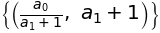

In [35]:
sp.nonlinsolve([a0-b0*b1,a1-b1+1],[b0, b1])

so we can add a pair  (a0*x**a1, a0/(a1+1)*x**(a1+1)).

But special case of a1==-1 is ignored.

So that we don't use a backward method yet.

## 4. Syntax tree works as a pre-process method



## 5. Post-process method is useful also.

3*x**5 ==> a0*x**a1 ==> `a0*Piecewise((x** (a1 + 1)/(a1 + 1), Ne(a1, -1)), (log(x), True))` ==> x**6/2 

In [36]:
a0=sp.symbols("a0")
exp=x**a0
exp.subs([(a0,2)])

In [37]:
F=sp.integrate(a0*x**a1,x)
F

   ⎛⎧ a₁ + 1             ⎞
   ⎜⎪x                   ⎟
   ⎜⎪───────  for a₁ ≠ -1⎟
a₀⋅⎜⎨ a₁ + 1             ⎟
   ⎜⎪                    ⎟
   ⎜⎪log(x)    otherwise ⎟
   ⎝⎩                    ⎠

In [38]:
str(F)

'a0*Piecewise((x**(a1 + 1)/(a1 + 1), Ne(a1, -1)), (log(x), True))'

In [39]:
F.subs([(a0,3),(a1,5)])

# Some utilities to process expression tree

In [40]:
rng=np.random.RandomState(0)


import functools
from concurrent import futures
 
executor = futures.ThreadPoolExecutor(1)
 
def timeout(seconds):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kw):
            future = executor.submit(func, *args, **kw)
            return future.result(timeout=seconds)
        return wrapper
    return decorator

@timeout(60)
def f2F_integrate(f_expr_list):
  infix = env.prefix_to_infix(f_expr_list)
  # print(infix)
  f = env.infix_to_sympy(infix)

  # remove additive constant, re-index coefficients
  # if rng.randint(2) == 0:
  #     f = remove_root_constant_terms(f, x, 'add')
  # print(f)

  if False: # To improve efficiency
    f = env.reduce_coefficients(f)
    f = env.simplify_const_with_coeff(f)
    f = env.reindex_coefficients(f)

  # print("f type:",type(f), "f",f)
  # compute its primitive, and rewrite it

  F = sp.integrate(f, x)
  # F=sp.integrate("x**a0",x, risch=False)
  # print("F:",F)
  return f, F



In [41]:
# To integrate a expression list
def f2F_integrate(f_expr_list):
  infix = env.prefix_to_infix(f_expr_list)
  # print(infix)
  f = env.infix_to_sympy(infix)

  # remove additive constant, re-index coefficients
  # if rng.randint(2) == 0:
  #     f = remove_root_constant_terms(f, x, 'add')
  # print(f)
  f = env.reduce_coefficients(f)
  f = env.simplify_const_with_coeff(f)
  f = env.reindex_coefficients(f)

  # print("f type:",type(f), "f",f)
  # compute its primitive, and rewrite it

  F = sp.integrate(f, x)
  # F=sp.integrate("x**a0",x, risch=False)
  # print("F:",F)
  return f, F

In [42]:
# To diff a expression list
@timeout(60)
def f2F_diff(f_expr_list):
  infix = env.prefix_to_infix(f_expr_list)
  # print(infix)
  f = env.infix_to_sympy(infix)

  # remove additive constant, re-index coefficients
  # if rng.randint(2) == 0:
  #     f = remove_root_constant_terms(f, x, 'add')
  # print(f)

  if False: # To improve efficiency
    f = env.reduce_coefficients(f)
    f = env.simplify_const_with_coeff(f)
    f = env.reindex_coefficients(f)

  # print("f type:",type(f), "f",f)
  # compute its primitive, and rewrite it

  F = sp.diff(f, x)
  # F=sp.integrate("x**a0",x, risch=False)
  # print("F:",F)
  return f, F


In [43]:
def generize_prefix(f_expr_list):
  n=[]
  i=0
  # in_num=False
  for ff in f_expr_list:
    if ff in ["INT+","INT-","INT"]:
      continue
    if ff.isnumeric():
      # if (not in_num):
        n.append(f"a{i}")
        i+=1
        # in_num=True
      # else:
      #   nn=n[-1]
      #   n=n[:-2]
      #   n.append(nn)
    else:
      n.append(ff)
      # in_num=False
  return n

In [44]:
f3=generize_prefix("mul x pow add x pow x INT+ 3 INT- 1".split())
print(f3)

f3,F3= f2F_integrate(f3)
print(f3,"==>", F3)

['mul', 'x', 'pow', 'add', 'x', 'pow', 'x', 'a0', 'a1']
x*(x + x**a0)**a1 ==> Integral(x*(x + x**a0)**a1, x)


### This should be a bug

So use sp.integrate("x") instead of sp.integrate("x",x)

Or maybe we cannot mix use string with other 

In [45]:
x_by_str=sp.sympify("x")
x_by_str==x

False

In [46]:
sp.integrate(x_by_str,x_by_str)

In [47]:
sp.integrate("x",x_by_str)

In [48]:
sp.integrate("x",x)

# To download the original samples

The data file is too big. The unzipped file is more than 14 Gb, so we won't process it in Jupyter notebook.

In [49]:
# !wget https://dl.fbaipublicfiles.com/SymbolicMathematics/data/prim_fwd.tar.gz
# !tar -xzvf /content/prim_fwd.tar.gz -C /content/drive/MyDrive/AI/SymbolicMath/

# To split the dataset

The reason to split the dataset is to use multiprocessing to improve the efficiency. In detail, maybe a few processes can work on different sub-files. So that we may improve the efficiency with times speed.

In [50]:
# Not used yet
def split_data(path):
  import io
  data=[]
  if path is not None:
    with io.open(path, mode='r', encoding='utf-8') as f:
                  # either reload the entire file, or the first N lines (for the training set)
      
      of= open("output000001", "w")

      lines = []
      for i, line in enumerate(f):
        of.write(line)
        if (i>0) and ((i+1) % 1000000==0):
          of.close()
          of= open("output"+str(i+1), "w")
      
      of.close()

In [51]:

path="/content/drive/MyDrive/AI/SymbolicMath/prim_fwd.valid"

if False: # for testing
  split_data(path)

In [52]:
!ls
!rm ./output*

master.zip  master.zip.1  sample_data  src  SymbolicMathematics-master
rm: cannot remove './output*': No such file or directory


# To turn the original value based samples into symbolic ones

In [57]:

import io
path="/content/prim_fwd.valid" # we use this file to test
data=[]
if path is not None:
  with io.open(path, mode='r', encoding='utf-8') as f:
                # either reload the entire file, or the first N lines (for the training set)
      lines = []
      for i, line in enumerate(f):
        # if i == 100:
        #   break
        lines.append(line.rstrip().split('|'))
      data = [xy.split('\t') for _, xy in lines]
      data = [xy for xy in data if len(xy) == 2]

In [58]:
print(len(data))
print(data[:10])
print(data[-1])

9985
[["sub Y' pow x INT+ 2", 'mul div INT+ 1 INT+ 3 pow x INT+ 3'], ["sub Y' add x pow x INT+ 3", 'add mul div INT+ 1 INT+ 2 pow x INT+ 2 mul div INT+ 1 INT+ 4 pow x INT+ 4'], ["sub Y' ln x", 'add mul INT- 1 x mul x ln x'], ["sub Y' add x ln x", 'add mul div INT+ 1 INT+ 2 pow x INT+ 2 add mul INT- 1 x mul x ln x'], ["sub Y' pow x div INT+ 5 INT+ 2", 'mul div INT+ 2 INT+ 7 pow x div INT+ 7 INT+ 2'], ["sub Y' mul INT+ 4 pow x INT- 1", 'mul INT+ 4 ln x'], ["sub Y' mul INT+ 9 pow x INT+ 2", 'mul INT+ 3 pow x INT+ 3'], ["sub Y' add x mul INT+ 5 pow x INT+ 2", 'add mul div INT+ 1 INT+ 2 pow x INT+ 2 mul div INT+ 5 INT+ 3 pow x INT+ 3'], ["sub Y' ln pow x INT+ 3", 'add mul INT- 3 x mul x ln pow x INT+ 3'], ["sub Y' mul x add x mul INT- 1 pow x INT+ 2", 'add mul div INT- 1 INT+ 4 pow x INT+ 4 mul div INT+ 1 INT+ 3 pow x INT+ 3']]
["sub Y' mul pow x div INT- 1 INT+ 2 pow add mul INT- 5 sinh INT+ 1 mul INT+ 4 0 x INT- 1", 'add mul div INT- 1 INT+ 2 0 mul sqrt INT+ 2 mul pow sinh INT+ 1 div INT-

In [59]:
def generate_dataset(data):
  result=[]
  i=0
  for f0, f_integrate in data:
    print(i, end="\r")
    i+=1

    if i<500:
        continue

    try:
      # print(f0)

      f1=f0.split()[2:]

      # print(f_expr)
      # print(f1)

      if False:
        f1,F1=f2F_integrate(f1)
        f1_prefix=env.sympy_to_prefix(sp.simplify(f1))
        f1_infix=env.prefix_to_infix(f1_prefix)
      else:
        f1_prefix=f1

      # print(f1_infix)
      # print(type(f_expr))
      f2=generize_prefix(f1_prefix)
      # print(f2)
      _,F2=f2F(f2)

      #result.append((str(f0),str(f1),str(f2),str(F2)))
    except TimeoutError:
      print("Timeout:", i)
    except:
      print("Unexpected error:(@", i,"),",sys.exc_info()[0])
      # print("Exception:", i, "==", f0)
      # if f1:
      #   print("f1:",f1)
      #   if f1_prefix:
      #     print("f1_prefix", f1_prefix)
      #     # if f1_infix:
      #     #   print("f1_infix", f1_infix)
      #     if f2:
      #       print("f2:",f2)
      #       if F2:
      #         print("F2:",F2)



In [60]:
def generate_dataset_diff(data):
  result=[]
  i=0
  succeeded=0
  timeouts=0
  invalids=0
  with open("diff","w") as outf:
    for f_integrate, f0 in data:
      print(i, end="\r")
      i+=1

      try:
        # print(f0)

        f1=f0.split()

        # print(f_expr)
        # print(f1)

        if False:
          f1,F1=f2F(f1)
          f1_prefix=env.sympy_to_prefix(sp.simplify(f1))
          f1_infix=env.prefix_to_infix(f1_prefix)
        else:
          f1_prefix=f1

        #print(f1_infix)
        # print(type(f_expr))
        f2=generize_prefix(f1_prefix)
        f2_infix = env.prefix_to_infix(f2)
        #print(f2)
        _,F2=f2F_diff(f2)
        #print(F2)

        F2_prefix=env.sympy_to_prefix(F2)
        
        #result.append((str(f0),str(f1),str(f2),str(F2)))

        #outf.write(str(f2)+"\t,"+str(f2_infix)+"\t,"+str(F2)+"\t"+str(F2_prefix)+"\n")
        outf.write(str(i)+"|sub Y' "+" ".join(f2)+"\t"+" ".join(F2_prefix)+"\n")
        succeeded+=1

      except TimeoutError:
        #print("Timeout:", i)
        timeouts+=1
      except:
        #print("Unexpected error:(@", i,"),",sys.exc_info()[0])
        invalids+=1

  print(succeeded," of ", len(data)," succeeded!")
  print(timeouts," of ", len(data)," timeouted!")
  print(invalids," of ", len(data)," are invalid!")
#get_ipython().run_line_magic('time', 'generate_dataset()')

In [61]:
from datetime import datetime

now1 = datetime.now()

current_time1 = now1.strftime("%H:%M:%S")

generate_dataset_diff(data)

now = datetime.now()

print("Start Time =", current_time1)
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

3995  of  9985  succeeded!
0  of  9985  timeouted!
5990  of  9985  are invalid!
Start Time = 09:42:31
End Time = 09:43:17


# Conclusion: Use Derivative instead of Integral

During the test, more than 80% generated symbolic samples cannot be integrated in 1 minutes.

The 45m samples may take a year to be turned into symbolic ones.

I don't have too much resources to do the data generation in this way. So that I will give up on the integral work. Instead I will use derivaitive. The test shows about 50% value-based samples can be turned into differentiatable symbolic samples.

